In [ ]:
#!kill -9 -1

In [ ]:
import numpy as np
import pandas as pd
import os, json, gc, re, random
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import logging
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

In [ ]:

#%%time


!pip uninstall -q torch -y
# 
!python3 -m pip install -q torch==1.6.0 -f https://download.pytorch.org/whl/torch_stable.html
!python3 -m pip install -q -U tokenizers==0.7.0 > /dev/null
!python3 -m pip install -q -U transformers==3.0.2 > /dev/null
!python3 -m pip install -q -U simpletransformers==0.46.0 > /dev/null


     |████████████████████████████████| 552.8MB 30kB/s 
ERROR: torchvision 0.9.1+cu101 has requirement torch==1.8.1, but you'll have torch 1.6.0+cu92 which is incompatible.
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.6.0+cu92 which is incompatible.
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.6.0+cu92 which is incompatible.


In [ ]:
#!pip install torch==1.6.0 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
import torch, transformers, tokenizers
torch.__version__, transformers.__version__, tokenizers.__version__

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


('1.6.0+cu92', '3.0.2', '0.8.1.rc1')

In [ ]:
movies_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LTP/wiki_movie_plots_deduped.csv")

In [ ]:
genre_counts = movies_df.groupby('Genre').count().iloc[:,0]


In [ ]:
#data pre-processing

movies_df = movies_df[(movies_df["Origin/Ethnicity"]=="American") | (movies_df["Origin/Ethnicity"]=="British")]
movies_df = movies_df[["Plot", "Genre"]]
drop_indices = movies_df[movies_df["Genre"] == "unknown" ].index
movies_df.drop(drop_indices, inplace=True)

# Combine genres: 1) "sci-fi" with "science fiction" &  2) "romantic comedy" with "romance"
movies_df["Genre"].replace({"sci-fi": "science fiction", "romantic comedy": "romance"}, inplace=True)

# Choosing movie genres based on their frequency
shortlisted_genres = movies_df["Genre"].value_counts().reset_index(name="count").query("count > 200")["index"].tolist()
movies_df = movies_df[movies_df["Genre"].isin(shortlisted_genres)].reset_index(drop=True)

# Shuffle DataFrame
movies_df = movies_df.sample(frac=1).reset_index(drop=True)

# Sample roughly equal number of movie plots from different genres (to reduce class imbalance issues)
movies_df = movies_df.groupby("Genre").head(400).reset_index(drop=True)

label_encoder = LabelEncoder()
movies_df["genre_encoded"] = label_encoder.fit_transform(movies_df["Genre"].tolist())

movies_df = movies_df[["Plot", "Genre", "genre_encoded"]]

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [ ]:
genre_counts = movies_df.groupby('Genre').count().iloc[:,0]

In [ ]:
#!python3 -m pip install simpletransformers

In [ ]:
from simpletransformers.classification import ClassificationModel

model_args = {
    "reprocess_input_data": True,
    "overwrite_output_dir": True,
    "save_model_every_epoch": False,
    "save_eval_checkpoints": False,
    "use_cuda" : True,
    "max_seq_length": 512,
    "train_batch_size": 16,
    "num_train_epochs": 4,
}

# Create a ClassificationModel
#model = ClassificationModel("roberta", "roberta-base", num_labels=len(shortlisted_genres), args=model_args)
#model = ClassificationModel("longformer", "allenai/longformer-base-4096", num_labels=len(shortlisted_genres), args=model_args)
model = ClassificationModel("xlnet", "xlnet-base-cased", num_labels=len(shortlisted_genres), args=model_args)


INFO:filelock:Lock 139813707016016 acquired on /root/.cache/torch/transformers/c9cc6e53904f7f3679a31ec4af244f4419e25ebc8e71ebf8c558a31cbcf07fc8.69e5e35e0b798cab5e473f253752f8bf4d280ee37682281a23eed80f6e2d09c6.lock


INFO:filelock:Lock 139813707016016 released on /root/.cache/torch/transformers/c9cc6e53904f7f3679a31ec4af244f4419e25ebc8e71ebf8c558a31cbcf07fc8.69e5e35e0b798cab5e473f253752f8bf4d280ee37682281a23eed80f6e2d09c6.lock


INFO:filelock:Lock 139811561845264 acquired on /root/.cache/torch/transformers/33d6135fea0154c088449506a4c5f9553cb59b6fd040138417a7033af64bb8f9.7eac4fe898a021204e63c88c00ea68c60443c57f94b4bc3c02adbde6465745ac.lock


INFO:filelock:Lock 139811561845264 released on /root/.cache/torch/transformers/33d6135fea0154c088449506a4c5f9553cb59b6fd040138417a7033af64bb8f9.7eac4fe898a021204e63c88c00ea68c60443c57f94b4bc3c02adbde6465745ac.lock


KeyboardInterrupt: ignored

In [ ]:
#torch.cuda.empty_cache()

train_df, eval_df = train_test_split(movies_df, test_size=0.2, stratify=movies_df["Genre"], random_state=42)

# Train the model
model.train_model(train_df[["Plot", "genre_encoded"]])

# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(eval_df[["Plot", "genre_encoded"]])
print(result)



INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


INFO:simpletransformers.classification.classification_model: Training of longformer model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


INFO:simpletransformers.classification.classification_model:{'mcc': 0.5214663115542357, 'eval_loss': 2.053286958782172}



{'mcc': 0.5214663115542357, 'eval_loss': 2.053286958782172}


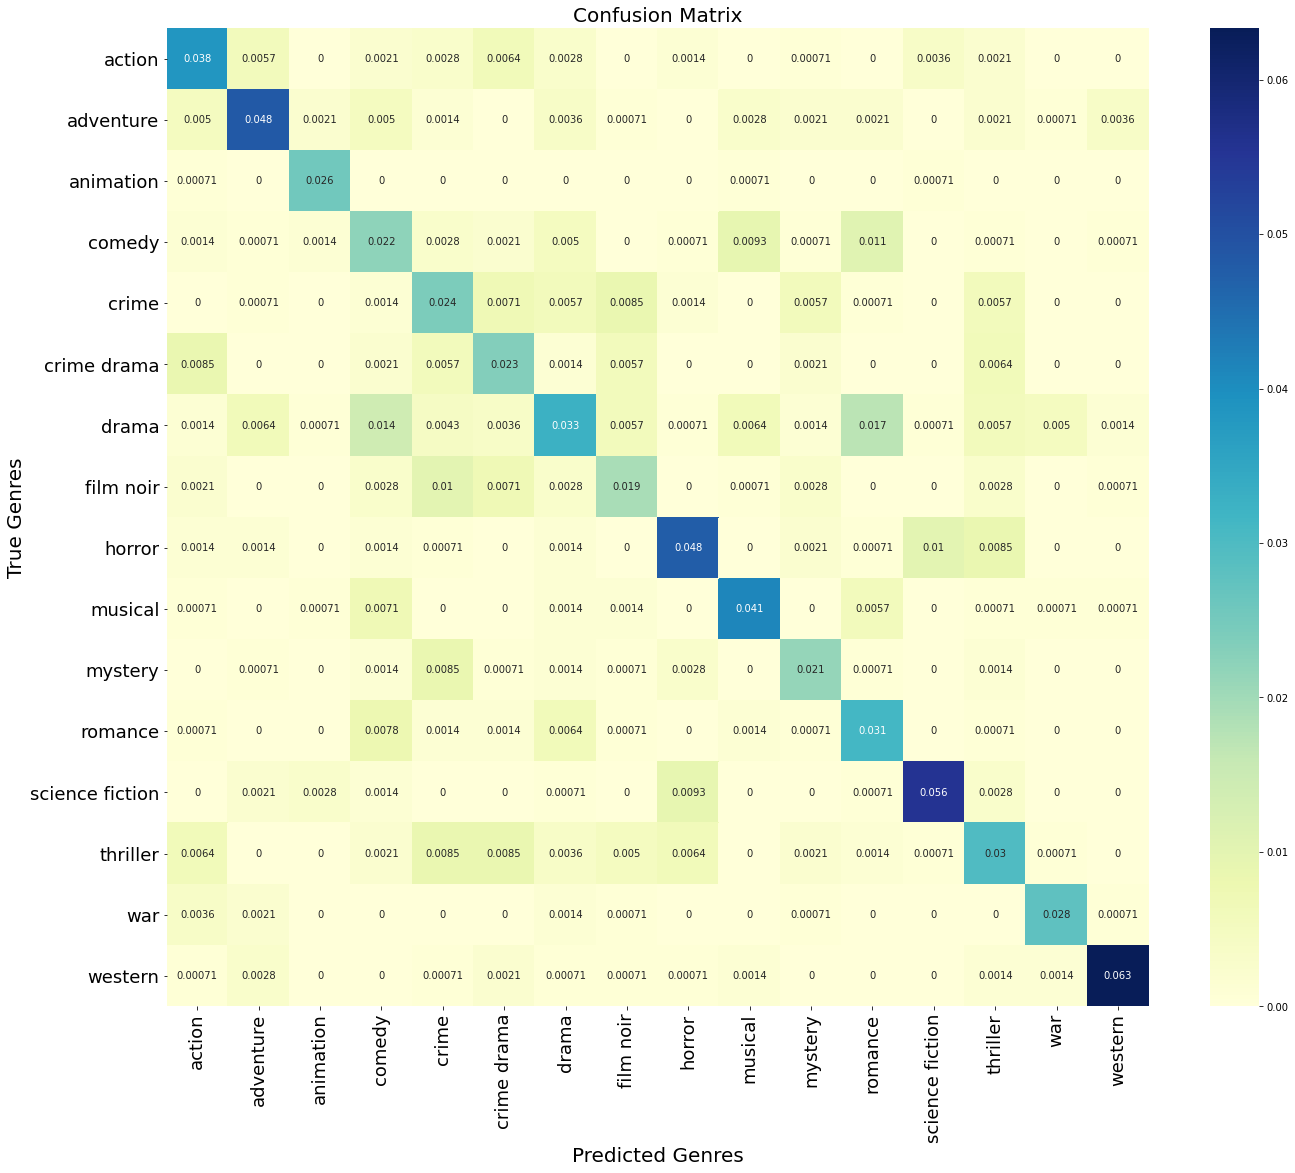

In [ ]:
predicted_genres_encoded = list(map(lambda x: np.argmax(x), model_outputs))
predicted_genres = list(label_encoder.inverse_transform(predicted_genres_encoded))
eval_gt_labels = eval_df["Genre"].tolist()
class_labels = list(label_encoder.classes_)

plt.figure(figsize=(22,18))
cf_matrix = confusion_matrix(predicted_genres, eval_gt_labels, class_labels)
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, cmap="YlGnBu")
ax.set_xlabel('Predicted Genres', fontsize=20)
ax.set_ylabel('True Genres', fontsize=20)
ax.set_title('Confusion Matrix', fontsize=20)
ax.set_xticklabels(class_labels, rotation=90, fontsize=18)
ax.set_yticklabels(class_labels, rotation=0, fontsize=18)

plt.show()

In [ ]:
random_idx = random.randint(0, len(eval_df)-1)
text = eval_df.iloc[random_idx]['Plot']
true_genre = eval_df.iloc[random_idx]['Genre']

# Predict with trained multiclass classification model
predicted_genre_encoded, raw_outputs = model.predict([text])
predicted_genre_encoded = np.array(predicted_genre_encoded)
predicted_genre = label_encoder.inverse_transform(predicted_genre_encoded)[0]

print(f'\nTrue Genre:'.ljust(16,' '), f'{true_genre}\n')
print(f'Predicted Genre: {predicted_genre}\n')
print(f'Plot: {text}\n')
print("-------------------------------------------")

INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.




True Genre:     drama

Predicted Genre: drama

Plot: As described in a film magazine,[3] believing he loves her, Elaine Bronson (Murray) at the death of her uncle marries Richard Earle (Cody). Before long, she discovers that he is more interested in her fortune, and so she accepts the attentions of Jimmy Newton (Dearholt). Richard has been having an affair with a married woman but tires of her, and comes to appreciate the beauty of his wife. However, she will have nothing to do with him. The other woman comes back to Richard and when she finds out about his marriage, she kills him, leaving Elaine and Jimmy free to pursue their happiness.

-------------------------------------------


In [ ]:
 num = 0
den = 0
for i in range(len(eval_gt_labels)):
  if predicted_genres[i] == eval_gt_labels[i]:
    num += 1
  den += 1

print(num/den)

0.5523131672597865
